## Estructura del dataset
Total de registros: 820
Columnas totales: 18
Variables relevantes: síntomas, temperatura, análisis de sangre, y resultado final.

## Diccionario
- id_paciente: ID del paciente, sirve como identificador único para cada registro.
- fecha_inicio_fiebre: Fecha de inicio de la fiebre. Indica cuándo comenzaron los síntomas febriles.
- lugar_residencia:Lugar de residencia del paciente, podría ser útil para análisis geográficos o epidemiológicos.
- dias_con_fiebre: Días desde el inicio de los síntomas. Representa el tiempo que ha pasado desde que el paciente comenzó a presentar signos de la enfermedad.
- temperatura_actual: Temperatura corporal actual del paciente, probablemente en grados Celsius.
- globulos_blancos:Recuento de glóbulos blancos (White Blood Cells). Un valor alterado puede indicar infección o inflamación.
- dolor_cabeza_severo:Presencia de dolor de cabeza severo.
- dolor_detras_ojos: Dolor detrás de los ojos, un síntoma común del dengue. Probablemente también binario.
- dolor_articular_muscular: Dolores articulares y musculares. Otro síntoma característico del dengue.
- sabor_metalico_boca: Sabor metálico en la boca. No es un síntoma tan común, pero puede estar presente.
- perdida_apetito: Pérdida de apetito. Frecuente en pacientes con fiebre o enfermedades virales.
- dolor_abdominal: Dolor abdominal.
- nauseas_vomitos: Náuseas o vómitos. Común en infecciones virales y particularmente en dengue.
- diarrea: Diarrea. Otro síntoma que puede presentarse con el dengue.
- hemoglobina: Nivel de hemoglobina en la sangre. Un nivel bajo puede indicar anemia o hemorragia.
- hematocrito: Mide el porcentaje de glóbulos rojos en la sangre. Importante para detectar concentración de sangre o signos de shock.
- plaquetas:Conteo de plaquetas. En dengue suele disminuir considerablemente, por lo que es un indicador clave.
- dengue: Etiqueta que indica si el paciente fue diagnosticado con dengue o no. Es la variable objetivo (target) para modelos de predicción.

## 1. Carga y preprocesamiento inicial de los datos

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score, confusion_matrix, f1_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

df = pd.read_csv('dengueSintomas.csv')

print(df.isnull().sum())

id_paciente                 0
fecha_inicio_fiebre         0
dias_con_fiebre             0
temperatura_actual          0
globulos_blancos            0
dolor_cabeza_severo         0
dolor_detras_ojos           0
dolor_articular_muscular    0
sabor_metalico_boca         0
perdida_apetito             0
dolor_abdominal             0
nauseas_vomitos             0
diarrea                     0
hemoglobina                 0
hematocrito                 0
plaquetas                   0
dengue                      0
dtype: int64


In [2]:
# Obtener información sobre las columnas y sus tipos de datos
df.info()

# Verificar la cantidad de valores nulos
df.isnull().sum()

# Ver estadísticas descriptivas
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_paciente               1820 non-null   object 
 1   fecha_inicio_fiebre       1820 non-null   object 
 2   dias_con_fiebre           1820 non-null   float64
 3   temperatura_actual        1820 non-null   float64
 4   globulos_blancos          1820 non-null   float64
 5   dolor_cabeza_severo       1820 non-null   object 
 6   dolor_detras_ojos         1820 non-null   object 
 7   dolor_articular_muscular  1820 non-null   object 
 8   sabor_metalico_boca       1820 non-null   object 
 9   perdida_apetito           1820 non-null   object 
 10  dolor_abdominal           1820 non-null   object 
 11  nauseas_vomitos           1820 non-null   object 
 12  diarrea                   1820 non-null   object 
 13  hemoglobina               1820 non-null   float64
 14  hematocr

,dias_con_fiebre,temperatura_actual,globulos_blancos,hemoglobina,hematocrito,plaquetas
count,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000
mean,6.432967,103.087912,3.025000,13.351786,32.080769,96.276374
std,3.601724,21.860645,1.272635,3.142119,7.385822,33.702430
min,1.000000,99.000000,1.000000,7.600000,18.000000,35.000000
25%,4.000000,102.000000,2.100000,10.600000,26.000000,74.000000
50%,6.000000,103.000000,2.950000,13.400000,32.000000,95.000000
75%,8.000000,104.000000,4.000000,15.900000,38.000000,120.000000
max,21.000000,1033.000000,24.000000,19.800000,47.000000,875.000000


In [3]:
# Convertir la columna de fecha en formato datetime
df['fecha_inicio_fiebre'] = pd.to_datetime(df['fecha_inicio_fiebre'], format='%d-%b')

# Convertir las columnas con valores binarios a tipo 'category'
columnas_categoricas = [
    'dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
    'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
    'nauseas_vomitos', 'diarrea', 'dengue'
]

df['dias_con_fiebre'] = df['dias_con_fiebre'].astype('int')

df.info()
df.describe()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_paciente               1820 non-null   object        
 1   fecha_inicio_fiebre       1820 non-null   datetime64[ns]
 2   dias_con_fiebre           1820 non-null   int64         
 3   temperatura_actual        1820 non-null   float64       
 4   globulos_blancos          1820 non-null   float64       
 5   dolor_cabeza_severo       1820 non-null   object        
 6   dolor_detras_ojos         1820 non-null   object        
 7   dolor_articular_muscular  1820 non-null   object        
 8   sabor_metalico_boca       1820 non-null   object        
 9   perdida_apetito           1820 non-null   object        
 10  dolor_abdominal           1820 non-null   object        
 11  nauseas_vomitos           1820 non-null   object        
 12  diarrea             

,id_paciente,fecha_inicio_fiebre,dias_con_fiebre,temperatura_actual,globulos_blancos,dolor_cabeza_severo,dolor_detras_ojos,dolor_articular_muscular,sabor_metalico_boca,perdida_apetito,dolor_abdominal,nauseas_vomitos,diarrea,hemoglobina,hematocrito,plaquetas,dengue
0,P001,1900-01-13,10,100.0,5.0,yes,no,no,yes,yes,yes,no,yes,15.0,21,140,yes
1,P002,1900-02-13,4,104.0,1.0,no,yes,yes,no,no,no,no,no,9.0,22,80,no
2,P003,1900-01-09,5,104.0,4.3,yes,no,no,yes,yes,yes,yes,no,9.3,24,120,yes
3,P004,1900-08-12,12,101.0,1.8,yes,yes,no,no,no,no,no,no,11.2,25,50,no
4,P005,1900-10-12,3,101.0,3.2,yes,no,no,no,no,no,yes,no,13.6,22,95,no


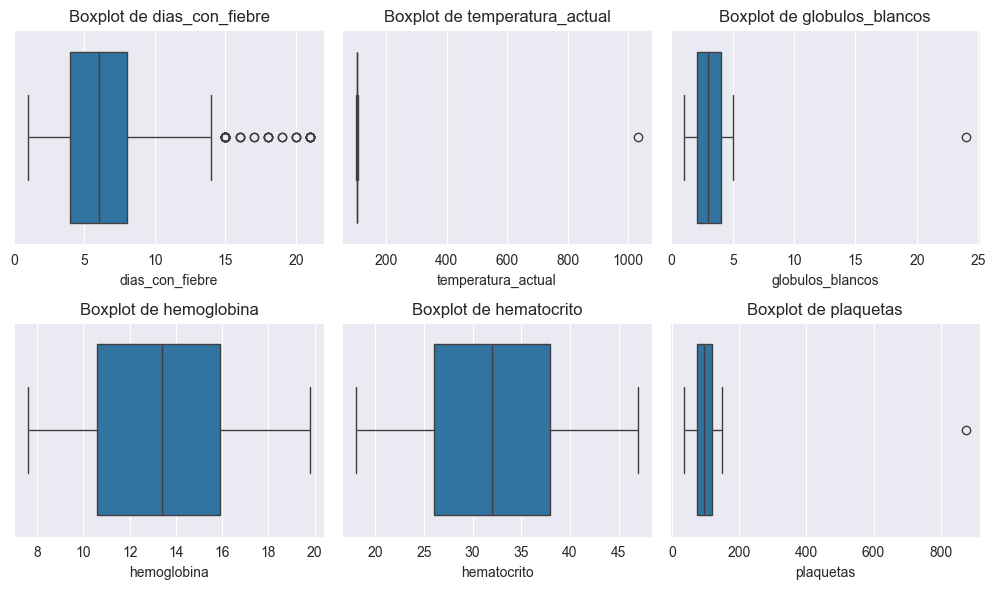

In [4]:
# Visualización de Outliers: Boxplots antes del tratamiento

# Columnas numéricas relevantes para el análisis
columnas_numericas = ['dias_con_fiebre', 'temperatura_actual', 'globulos_blancos',
                      'hemoglobina', 'hematocrito', 'plaquetas']

# Crear un gráfico de caja (boxplot) para cada una de las columnas numéricas
plt.figure(figsize=(10, 6))
for i, columna in enumerate(columnas_numericas, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[columna])
    plt.title(f'Boxplot de {columna}')

plt.tight_layout()
plt.show()


In [5]:
# Imputar valores atípicos con la mediana
for columna in columnas_numericas:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df[columna] = np.where(df[columna] < limite_inferior, df[columna].median(), df[columna])
    df[columna] = np.where(df[columna] > limite_superior, df[columna].median(), df[columna])


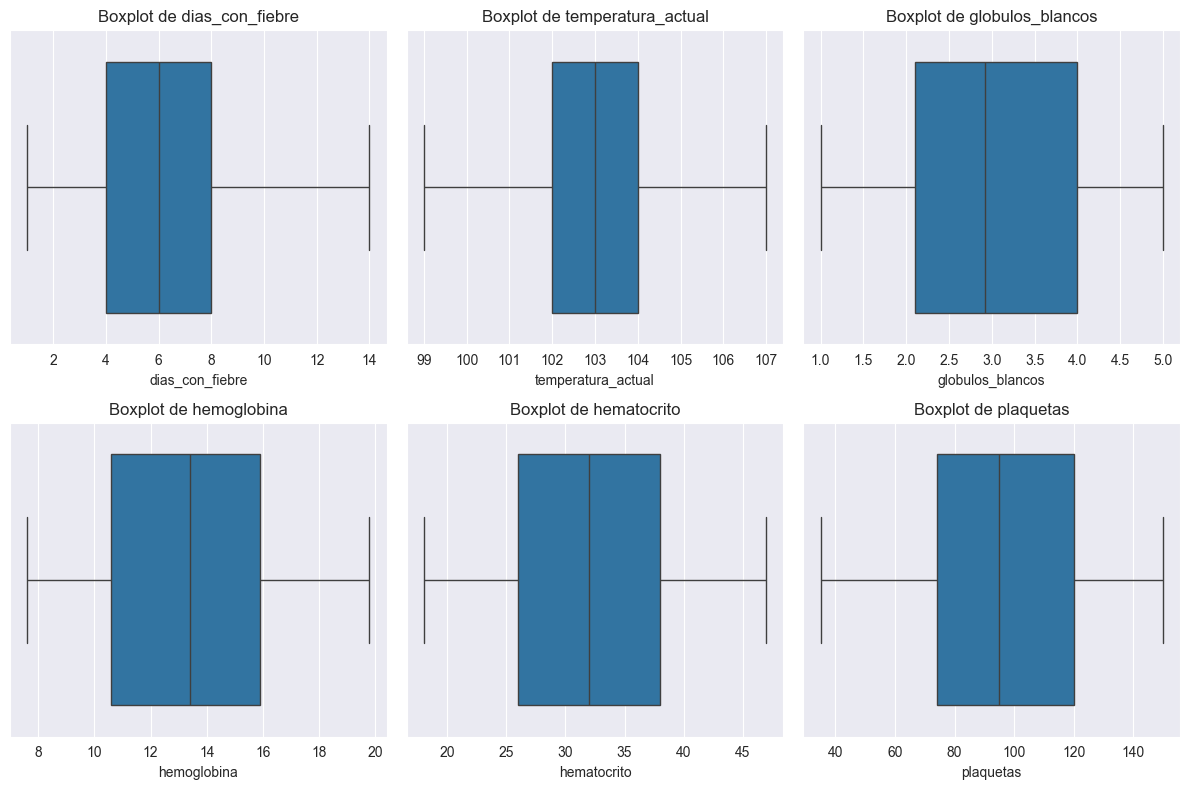

In [6]:
# Visualización de Outliers: Boxplots después del tratamiento

plt.figure(figsize=(12, 8))
for i, columna in enumerate(columnas_numericas, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[columna])
    plt.title(f'Boxplot de {columna}')

plt.tight_layout()
plt.show()


## 2. Preparación de los datos para el modelo de Machine Learning

In [7]:
# Lista de columnas que contienen respuestas tipo "yes"/"no"
columnas_binarias = [
    'dolor_cabeza_severo',
    'dolor_detras_ojos',
    'dolor_articular_muscular',
    'sabor_metalico_boca',
    'perdida_apetito',
    'dolor_abdominal',
    'nauseas_vomitos',
    'diarrea',
    'dengue'  # también es binaria y la usaremos como variable objetivo
]

# Convertimos los valores: 'yes' -> 1 y 'no' -> 0
df[columnas_binarias] = df[columnas_binarias].replace({'yes': 1, 'no': 0})

# Verificamos los primeros registros de estas columnas para asegurarnos que la conversión fue correcta
print(df[columnas_binarias].head())


   dolor_cabeza_severo  dolor_detras_ojos  dolor_articular_muscular  \
0                    1                  0                         0   
1                    0                  1                         1   
2                    1                  0                         0   
3                    1                  1                         0   
4                    1                  0                         0   

   sabor_metalico_boca  perdida_apetito  dolor_abdominal  nauseas_vomitos  \
0                    1                1                1                0   
1                    0                0                0                0   
2                    1                1                1                1   
3                    0                0                0                0   
4                    0                0                0                1   

   diarrea  dengue  
0        1       1  
1        0       0  
2        0       1  
3        0       0  
4    

C:\Users\angel\AppData\Local\Temp\ipykernel_17284\1753040816.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columnas_binarias] = df[columnas_binarias].replace({'yes': 1, 'no': 0})


## 3. XGboost


Resultados con XGBoost (usando PCA)
Accuracy: 0.9890
AUC-ROC: 0.9996
Recall (Sensibilidad): 0.9908
Tiempo de predicción: 0.0014 segundos
Especificidad: 0.9864
Tasa de Falsos Positivos (FPR): 0.0136
F1-Score: 0.9908


C:\Users\angel\PycharmProjects\Dengue_Backend\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:54:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


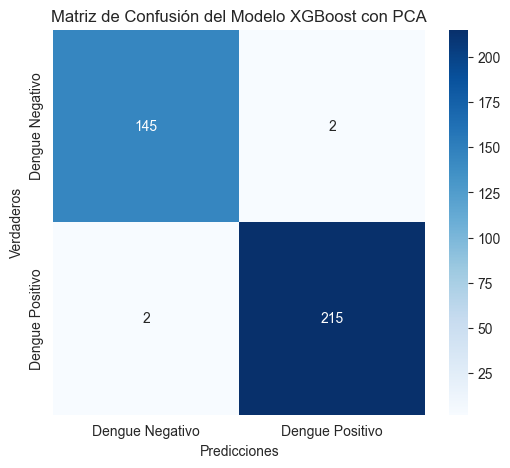

In [8]:
# 1. Definir columnas
columnas_numericas = ['dias_con_fiebre']
columnas_no_numericas = [
    'dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
    'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
    'nauseas_vomitos', 'diarrea'
]
columnas_completas = columnas_numericas + columnas_no_numericas

# 2. Escalar solo las columnas numéricas
scaler = StandardScaler()
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

# 3. Aplicar PCA
pca = PCA(n_components=6)
X_pca = pca.fit_transform(df[columnas_completas])
df_pca = pd.DataFrame(X_pca, columns=[f'Componente {i+1}' for i in range(6)])

# 4. Preparar variables
X = df_pca
y = df['dengue']

# 5. División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Crear y entrenar clasificador XGBoost
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# 7. Predicciones
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# 8. Evaluación
print("\nResultados con XGBoost (usando PCA)")

accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_xgb:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_xgb = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc_xgb:.4f}")

recall_xgb = recall_score(y_test, y_pred)
print(f"Recall (Sensibilidad): {recall_xgb:.4f}")

start_time = time.time()
_ = xgb_clf.predict(X_test)
prediction_time_xgb = time.time() - start_time
print(f"Tiempo de predicción: {prediction_time_xgb:.4f} segundos")

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity_xgb = tn / (tn + fp)
print(f"Especificidad: {specificity_xgb:.4f}")

fpr_value_xgb = fp / (tn + fp)
print(f"Tasa de Falsos Positivos (FPR): {fpr_value_xgb:.4f}")

f1_xgb = f1_score(y_test, y_pred)
print(f"F1-Score: {f1_xgb:.4f}")

# 9. Matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dengue Negativo', 'Dengue Positivo'],
            yticklabels=['Dengue Negativo', 'Dengue Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión del Modelo XGBoost con PCA')
plt.show()

## 7. Guardar el modelo entrenado

In [9]:
import joblib

# Suponiendo que tu modelo XGBoost se llama xgb_clf
joblib.dump(xgb_clf, 'modelo_xgboost_ajustado.pkl')

['modelo_xgboost_ajustado.pkl']

In [10]:
import json
import os

ruta_json = 'metricas_modelos.json'

# Cargar JSON existente o crear uno nuevo
if os.path.exists(ruta_json):
    with open(ruta_json, "r") as f:
        metricas_modelos = json.load(f)
else:
    metricas_modelos = {}

# Añadir o actualizar las métricas de XGBoost
metricas_modelos["xgboost"] = {
    "accuracy": accuracy_xgb,
    "auc_roc": roc_auc_xgb,
    "recall": recall_xgb,
    "specificity": specificity_xgb,
    "fpr": fpr_value_xgb,
    "f1_score": f1_xgb,
    "prediction_time": prediction_time_xgb
}

# Guardar el JSON actualizado
with open(ruta_json, "w") as f:
    json.dump(metricas_modelos, f, indent=4)

## AJUSTE DE HIPERPARAMETROS

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.7}

Resultados con XGBoost (mejor modelo)
Accuracy: 0.9863
AUC-ROC: 0.9995
Recall (Sensibilidad): 0.9908
Tiempo de predicción: 0.0029 segundos
Especificidad: 0.9796
Tasa de Falsos Positivos (FPR): 0.0204
F1-Score: 0.9885


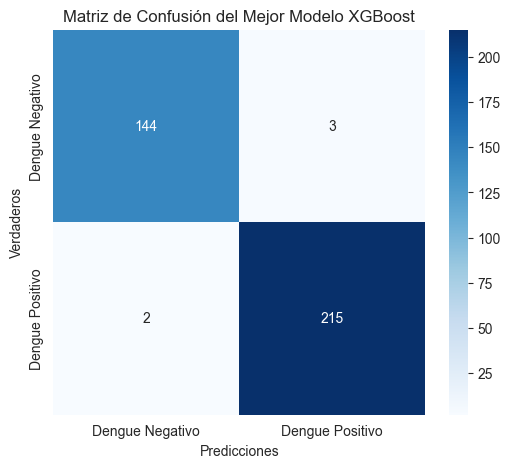

In [11]:
# Columnas numéricas y síntomas
columnas_numericas = ['dias_con_fiebre']
columnas_no_numericas = ['dolor_cabeza_severo', 'dolor_detras_ojos', 'dolor_articular_muscular',
                         'sabor_metalico_boca', 'perdida_apetito', 'dolor_abdominal',
                         'nauseas_vomitos', 'diarrea']

# Estandarizar columnas numéricas
scaler = StandardScaler()
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

# Definir X e y
X = df[columnas_numericas + columnas_no_numericas]
y = df['dengue']

# Dividir dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el clasificador base
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
)

# Definir el grid de hiperparámetros a buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Ejecutar búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_xgb = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar mejor modelo
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

print("\nResultados con XGBoost (mejor modelo)")

accuracy_xgb_adjusted = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_xgb_adjusted:.4f}")

fpr_xgb_adjusted, tpr_xgb_adjusted, thresholds = roc_curve(y_test, y_prob)
roc_auc_xgb_adjusted = auc(fpr_xgb_adjusted, tpr_xgb_adjusted)
print(f"AUC-ROC: {roc_auc_xgb_adjusted:.4f}")

recall_xgb_adjusted = recall_score(y_test, y_pred)
print(f"Recall (Sensibilidad): {recall_xgb_adjusted:.4f}")

start_time = time.time()
y_pred_time = best_xgb.predict(X_test)
end_time = time.time()
prediction_time_xgb_adjusted = end_time - start_time
print(f"Tiempo de predicción: {prediction_time_xgb_adjusted:.4f} segundos")

cm_xgb_adjusted = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm_xgb_adjusted.ravel()
specificity_xgb_adjusted = tn / (tn + fp)
print(f"Especificidad: {specificity_xgb_adjusted:.4f}")

fpr_value_xgb_adjusted = fp / (tn + fp)
print(f"Tasa de Falsos Positivos (FPR): {fpr_value_xgb_adjusted:.4f}")

f1_xgb_adjusted = f1_score(y_test, y_pred)
print(f"F1-Score: {f1_xgb_adjusted:.4f}")

# Graficar matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb_adjusted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dengue Negativo', 'Dengue Positivo'],
            yticklabels=['Dengue Negativo', 'Dengue Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión del Mejor Modelo XGBoost')
plt.show()

# GRAFICOS PARAMETROS SIN AJUSTAR VS AJUSTADOS

# Precision

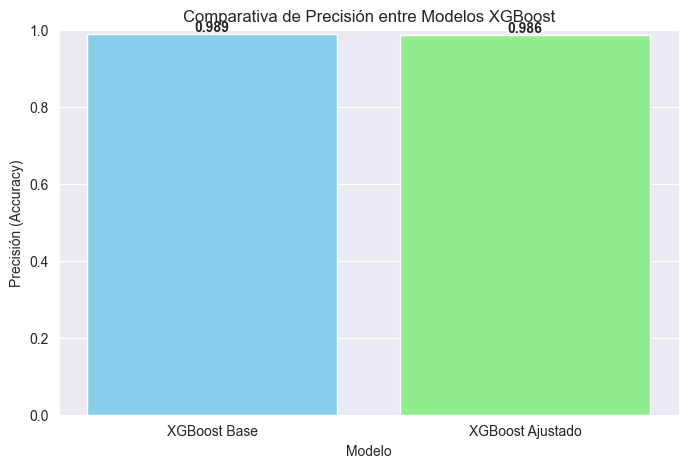

In [12]:
# Nombres para los dos modelos que comparas
modelos = ['XGBoost Base', 'XGBoost Ajustado']

# Valores de accuracy de los dos modelos (de tu código)
accuracy_scores = [accuracy_xgb, accuracy_xgb_adjusted]

# Crear figura y gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(modelos, accuracy_scores, color=['skyblue', 'lightgreen'])

plt.title('Comparativa de Precisión entre Modelos XGBoost')
plt.xlabel('Modelo')
plt.ylabel('Precisión (Accuracy)')
plt.ylim([0, 1])

# Añadir valor numérico sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0, f'{yval:.3f}', ha='center', va='bottom', fontweight='bold')

plt.show()

# Tasa de Falsos Positivos (FPR)

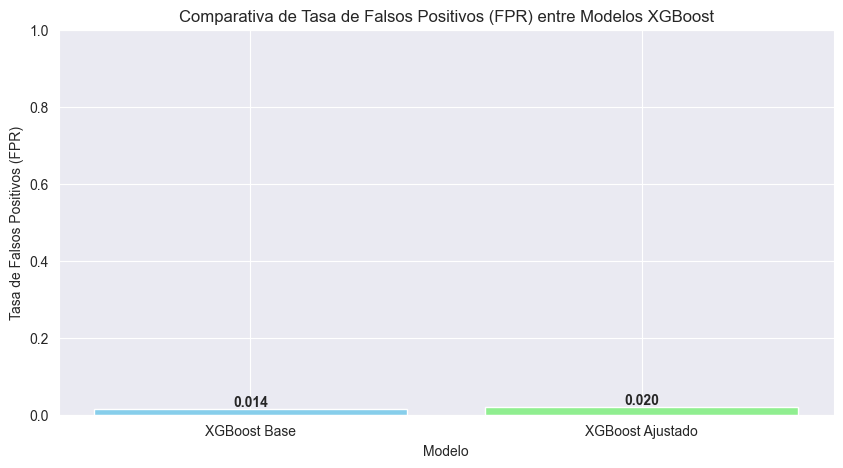

In [13]:
# Nombres para los dos modelos que comparas
modelos = ['XGBoost Base', 'XGBoost Ajustado']

# Valores de FPR de los dos modelos (asegúrate que estén definidos)
fpr_scores = [fpr_value_xgb, fpr_value_xgb_adjusted]

# Crear figura y gráfico de barras
plt.figure(figsize=(10, 5))
bars = plt.bar(modelos, fpr_scores, color=['skyblue', 'lightgreen'])

plt.title('Comparativa de Tasa de Falsos Positivos (FPR) entre Modelos XGBoost')
plt.xlabel('Modelo')
plt.ylabel('Tasa de Falsos Positivos (FPR)')
plt.ylim([0, 1])

# Añadir valor numérico sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0, f'{yval:.3f}', ha='center', va='bottom', fontweight='bold')

plt.show()

# SENSIBILIDAD (RECALL)

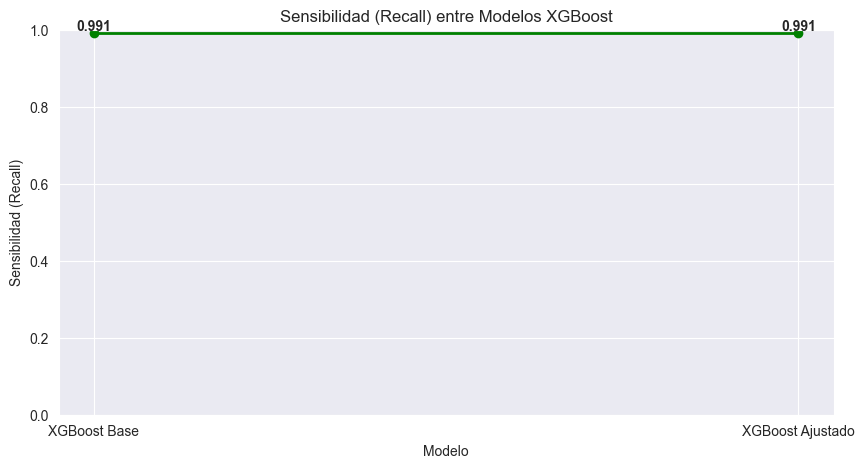

In [14]:
# Nombres para los dos modelos
modelos = ['XGBoost Base', 'XGBoost Ajustado']

# Valores de recall para los dos modelos (asegúrate que estén definidos)
recall_scores = [recall_xgb, recall_xgb_adjusted]

plt.figure(figsize=(10, 5))

# Gráfico de líneas para comparar recall
plt.plot(modelos, recall_scores, marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Sensibilidad (Recall) entre Modelos XGBoost')
plt.xlabel('Modelo')
plt.ylabel('Sensibilidad (Recall)')
plt.ylim([0, 1])
plt.grid(True)

# Añadir valores sobre cada punto
for i, val in enumerate(recall_scores):
    plt.text(modelos[i], val + 0, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.show()

# Tiempo de predicción

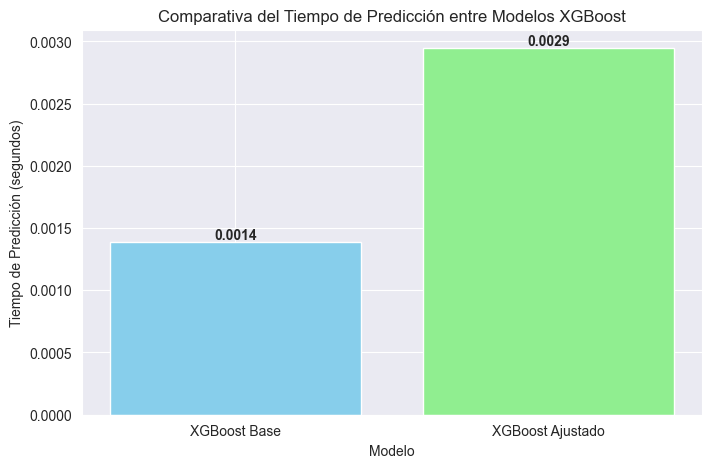

In [15]:
# Nombres para los dos modelos
modelos = ['XGBoost Base', 'XGBoost Ajustado']

# Tiempos de predicción (asegúrate que estén definidos)
prediction_times = [prediction_time_xgb, prediction_time_xgb_adjusted]

plt.figure(figsize=(8, 5))
bars = plt.bar(modelos, prediction_times, color=['skyblue', 'lightgreen'])

plt.title('Comparativa del Tiempo de Predicción entre Modelos XGBoost')
plt.xlabel('Modelo')
plt.ylabel('Tiempo de Predicción (segundos)')

# Añadir valores sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom', fontweight='bold')

plt.show()

# F1-Score

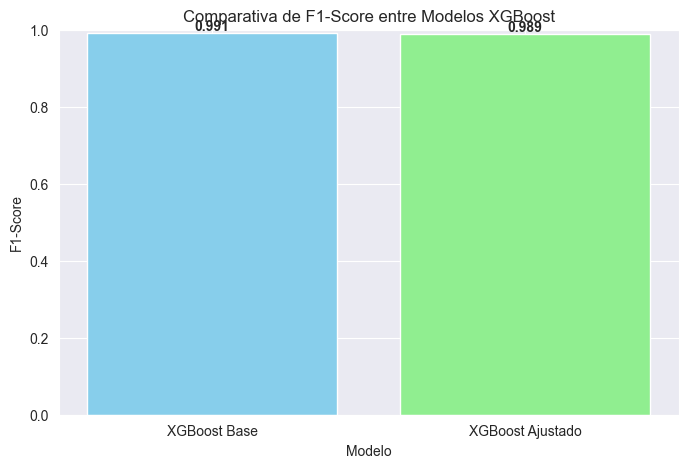

In [16]:
# Nombres para los dos modelos
modelos = ['XGBoost Base', 'XGBoost Ajustado']

# Valores de F1-Score (asegúrate que estén definidos)
f1_scores = [f1_xgb, f1_xgb_adjusted]

plt.figure(figsize=(8, 5))
bars = plt.bar(modelos, f1_scores, color=['skyblue', 'lightgreen'])

plt.title('Comparativa de F1-Score entre Modelos XGBoost')
plt.xlabel('Modelo')
plt.ylabel('F1-Score')
plt.ylim([0, 1])

# Añadir valores sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom', fontweight='bold')

plt.show()

# AUC-ROC

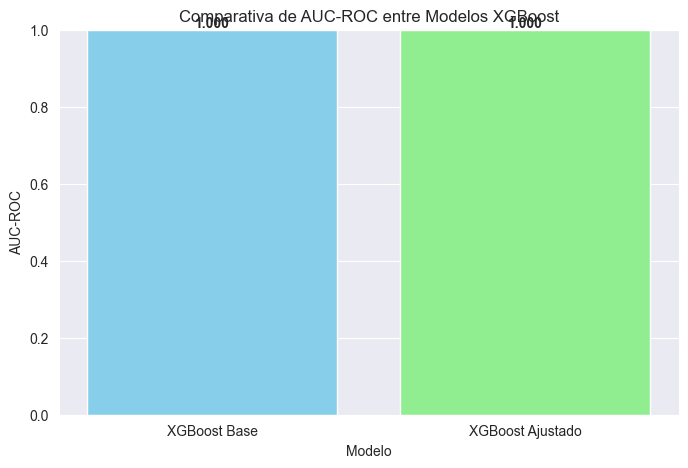

In [17]:
# Nombres para los dos modelos
modelos = ['XGBoost Base', 'XGBoost Ajustado']

# Valores de AUC-ROC (asegúrate que estén definidos)
auc_scores = [roc_auc_xgb, roc_auc_xgb_adjusted]

plt.figure(figsize=(8, 5))
bars = plt.bar(modelos, auc_scores, color=['skyblue', 'lightgreen'])

plt.title('Comparativa de AUC-ROC entre Modelos XGBoost')
plt.xlabel('Modelo')
plt.ylabel('AUC-ROC')
plt.ylim([0, 1])

# Añadir valores sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom', fontweight='bold')

plt.show()